<a target="_blank" href="https://colab.research.google.com/github/OnurKerimoglu/water_bodies/blob/main/nb/satellite-water-bodies-keras-sm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Notes and highlights

I created this notebook mainly by adapting the binary segmentation example from the tensorflow-version of the segmentation_models (sm) repository (https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb) to the 'satellite-images-of-water-bodies' dataset and by fixing the issues that probably emerged as a result of updates in some of the packages the meanwhile. 

I saw that in some other notebooks the entire data is loaded to the memory and processed before the training. This may work if the images are shrinked, but with original sizes, or by cropping (or padding) to 512x512, this approach can blow up the ram (it does currently in colab). Here, the processing is done in batches during the training (or validation), which has much lower memory requirements. 

Another highlight is the k-fold cross-validation: implementing this technique for sk-learn models is straightford, a little less so for deep learning models, especially when using data loaders as I did here. This notebook provides a full demonstration.

A final aspect I was curious about was the effects of Augmentations on the training performance, and my first impression is that the geometric transformations such as flipping, rotating, shifting did help the training performance, whereas the qualitative transformations (brightness, hue, etc) did not really help. More experimentation is needed in this regard. The aforementioned geometric transformations are optional, unlike the cropping/padding transformation that ascertains the input size, noting that no resizing is applied here to avoid potential issues with interpolating the masks.

## Setup

In [1]:

%matplotlib inline

In [2]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "segmentation-models"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "albumentations"])

0

In [3]:
import glob
import os

import albumentations as A
import cv2
import keras
import numpy as np
from matplotlib import pyplot as plt
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import segmentation_models as sm
from sklearn.model_selection import train_test_split, KFold

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-06 18:02:11.219498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749232931.245853     145 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749232931.254241     145 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [57]:
import os
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU'))!=0:
    HEIGHT, WIDTH = (512, 512)
    BATCH_SIZE = 16
    NUM_EPOCHS = 15
    ENCODER = 'resnet34'
    DEVICE = 'cuda'
    FLAG_CUDA = True
    percentdata2use = 100
    NUM_FOLDS = 4
else:  # this is for testing locally
    HEIGHT, WIDTH = (64, 64)
    BATCH_SIZE = 256
    NUM_EPOCHS = 5
    ENCODER = 'resnet18'
    DEVICE = 'cpu'
    FLAG_CUDA = False
    percentdata2use = 50
    NUM_FOLDS = 1
WEIGHTS = 'imagenet'
ROOTPATH = os.path.dirname(os.path.abspath(os.path.curdir))
print(f'rootpath: {ROOTPATH}, cuda available: {FLAG_CUDA}')

rootpath: /kaggle, cuda available: True


In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
franciscoescobar_satellite_images_of_water_bodies_path = kagglehub.dataset_download('franciscoescobar/satellite-images-of-water-bodies')

print('Data source import complete.')

Data source import complete.


In [6]:
franciscoescobar_satellite_images_of_water_bodies_path

'/kaggle/input/satellite-images-of-water-bodies'

In [7]:
Images_dir = os.path.join(franciscoescobar_satellite_images_of_water_bodies_path, 'Water Bodies Dataset', 'Images')
Masks_dir = os.path.join(franciscoescobar_satellite_images_of_water_bodies_path, 'Water Bodies Dataset', 'Masks')
image_paths = sorted(glob.glob(f'{Images_dir}/*'))
mask_paths = sorted(glob.glob(f'{Masks_dir}/*'))

num_images_to_use = round(len(image_paths) * percentdata2use / 100)
image_paths = image_paths[:num_images_to_use]
mask_paths = mask_paths[:num_images_to_use]

In [8]:
len(mask_paths)

2841

## Data Loading and Processing Functions

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    print(f'n images: {n}')
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

class Dataset:
    """WaterBody Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        image_paths (str): list of paths of images
        masks_paths (str): list of paths of masks
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_paths,
            masks_paths,
            augmentation=None,
            preprocessing=None,
    ):
        self.images_fps = images_paths
        self.masks_fps = masks_paths
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        mask= np.expand_dims(mask, axis=2)
        mask = mask/255.0
        mask = tf.cast(mask, dtype=tf.float32)
        return image, mask

    def __len__(self):
        return len(self.images_fps)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    def __init__(self, dataset, batch_size=1, shuffle=False):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

image shape: (176, 374, 3) - mask shape: (176, 374, 1)
n images: 2


I0000 00:00:1749232935.493782     145 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


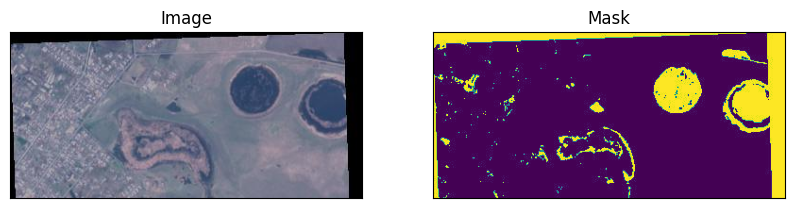

In [10]:
# Lets look at data we have
dataset = Dataset(image_paths, mask_paths)

image, mask = dataset[4] # get some sample
print(f'image shape: {image.shape} - mask shape: {mask.shape}')
visualize(
    image=image,
    mask=mask
)

In [11]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(Height, Width):
    train_transform = [

        A.RandomCrop(
            height=HEIGHT,
            width=WIDTH,
            pad_if_needed=True,
            p=1.0),#, always_apply=True),
        
        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0, rotate_limit=0.5, shift_limit=0.1, p=0.5, border_mode=0),

        A.Perspective(p=0.5),
        
        # A.AdditiveNoise('gaussian', p=0.2),
        
        # A.OneOf(
        #     [
        #         A.CLAHE(p=1),
        #         A.RandomBrightnessContrast(p=1),
        #         A.RandomGamma(p=1),
        #     ],
        #     p=0.5,
        # ),

        # A.OneOf(
        #     [
        #         A.Sharpen(p=1),
        #         A.Blur(blur_limit=3, p=1),
        #         A.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.5,
        # ),

        # A.OneOf(
        #     [
        #         A.HueSaturationValue(p=1),
        #     ],
        #     p=0.5,
        # ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(Height, Width):
    test_transform = [
        # Add paddings to make image shape divisible by 32
        # A.PadIfNeeded(384, 480)
        # A.PadIfNeeded(
        #     min_height=HEIGHT,
        #     min_width=WIDTH,
        #     p=1.0),
        A.RandomCrop(
            height=Height,
            width=Width,
            pad_if_needed=True,
            p=1.0)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


image shape: (512, 512, 3) - mask shape: (512, 512, 1)
n images: 2


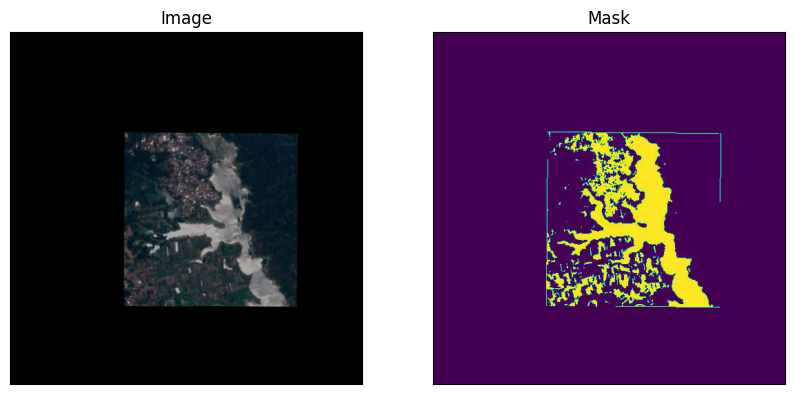

In [12]:
# Lets look at augmented data we have
dataset = Dataset(
    image_paths,
    mask_paths,
    augmentation=get_training_augmentation(HEIGHT, WIDTH))

# get some sample
num = 1
image, mask = dataset[num] 
print(f'image shape: {image.shape} - mask shape: {mask.shape}')
visualize(
    image=image,
    mask=mask
)

image shape: (512, 512, 3) - mask shape: (512, 512, 1)
n images: 2


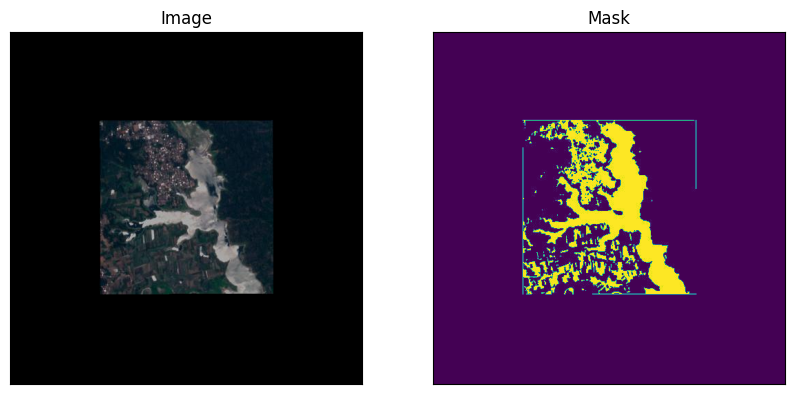

In [13]:
# same image, different augmentation
image, mask = dataset[num] 
print(f'image shape: {image.shape} - mask shape: {mask.shape}')
visualize(
    image=image,
    mask=mask
)

image shape: (512, 512, 3) - mask shape: (512, 512, 1)
n images: 2


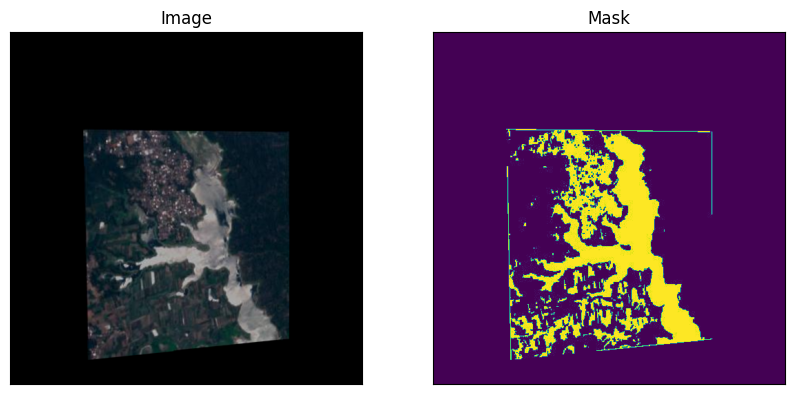

In [14]:
# same image, different augmentation
image, mask = dataset[num] 
print(f'image shape: {image.shape} - mask shape: {mask.shape}')
visualize(
    image=image,
    mask=mask
)

## Model Training

In [15]:
# train_ratio = 0.70
# validation_ratio = 0.15
test_ratio = 0.15

image_paths_trainval, image_paths_test, mask_paths_trainval, mask_paths_test = train_test_split(image_paths, mask_paths, test_size=test_ratio)

print(f'# Training + Testing images: {len(image_paths_trainval)} - # Test images: {len(image_paths_test)}')

# Training + Testing images: 2414 - # Test images: 427


In [19]:
test_dataloader[0][0].shape

(1, 512, 512, 3)

In [18]:
# preprocess test input and check whether dimensons are consistent
preprocess_input = sm.get_preprocessing(ENCODER)

test_dataset = Dataset(
    image_paths_test,
    mask_paths_test,
    augmentation=get_validation_augmentation(Height=HEIGHT, Width=WIDTH),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert test_dataloader[0][0].shape == (1, HEIGHT, WIDTH, 3)
assert test_dataloader[0][1].shape == (1, HEIGHT, WIDTH, 1)

In [91]:
def load_data_kfold(k):
    folds = list(
        KFold(
            n_splits=k,
            shuffle=True).split(image_paths_trainval, mask_paths_trainval))
    
    return folds

# number of folds
folds = load_data_kfold(NUM_FOLDS)

In [92]:
def get_model():
    # define model
    model = sm.Unet(ENCODER, encoder_weights=WEIGHTS)
    # bce_jaccard_loss = sm.losses.bce_jaccard_loss
    dice_loss = sm.losses.DiceLoss()
    bce_loss = sm.losses.BinaryCELoss()
    # focal_loss = sm.losses.BinaryFocalLoss()
    # total_loss = sm.losses.bce_dice_loss + (1 * focal_loss)
    total_loss = bce_loss + dice_loss
    
    model.compile(
        'Adam',
        # loss=bce_jaccard_loss,
        loss = total_loss,
        metrics=[sm.metrics.iou_score],)
    
    # print(model.summary())
    return model

def get_callbacks():
    path_training_logs = os.path.join(ROOTPATH, 'training_logs')
    if not os.path.exists(path_training_logs):
        os.makedirs(path_training_logs)
    
    path_models = os.path.join(ROOTPATH, 'models', 'keras_tensorflow_unet', ENCODER)
    if not os.path.exists(path_models):
        os.makedirs(path_models)
    
    
    EScallback = keras.callbacks.EarlyStopping(
        # monitor='val_loss',
        monitor='val_iou_score',
        mode='max',
        patience=3,
        min_delta=1e-3,
        restore_best_weights = True)
    
    CPcallback = keras.callbacks.ModelCheckpoint(
        os.path.join(path_models, 'best_model.keras'),
        save_weights_only=False,
        save_best_only=True,
        mode='min')
    
    RLRcallback =keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.1,
        patience=3,
        verbose=1,
        min_delta=1e-3,
        mode='min')

    # TBcallback = keras.callbacks.TensorBoard(
    #     log_dir=path_training_logs,
    #     histogram_freq=0,
    #     write_graph=True,
    #     write_images=False
    # )
    return [EScallback, CPcallback, RLRcallback] #, TBcallback]

In [93]:
# %load_ext tensorboard
# %tensorboard --logdir='../training_logs'

In [94]:
loss_per_fold = []
iou_per_fold = []
history_per_fold = []
for j, (train_idx, val_idx) in enumerate(folds):

    print (f'Fold: {j}:')
    image_paths_train = list(np.array(image_paths_trainval)[train_idx])
    mask_paths_train = list(np.array(mask_paths_trainval)[train_idx])

    image_paths_val = list(np.array(image_paths_trainval)[val_idx])
    mask_paths_val = list(np.array(mask_paths_trainval)[val_idx])
    
    print(f'# Training  images: {len(image_paths_train)} - # Val images: {len(image_paths_val)}')
    
    # Dataset for train images
    train_dataset = Dataset(
        image_paths_train,
        mask_paths_train,
        augmentation=get_training_augmentation(HEIGHT, WIDTH),
        preprocessing=get_preprocessing(preprocess_input),
    )
    
    # Dataset for validation images
    valid_dataset = Dataset(
        image_paths_val,
        mask_paths_val,
        augmentation=get_validation_augmentation(HEIGHT, WIDTH),
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
    
    assert train_dataloader[0][0].shape == (BATCH_SIZE, HEIGHT, WIDTH, 3)
    assert train_dataloader[0][1].shape == (BATCH_SIZE, HEIGHT, WIDTH, 1)

    model = get_model()
    callbacks = get_callbacks()
    
    history = model.fit(
       train_dataloader,
       batch_size=BATCH_SIZE,
       epochs=NUM_EPOCHS,
       validation_data=valid_dataloader,
       callbacks=callbacks,
       verbose=1
    )
    
    history_per_fold.append(history)

Fold: 0:
# Training  images: 1810 - # Val images: 604
Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 144s 778ms/step - iou_score: 0.3235 - loss: 0.8843 - val_iou_score: 0.0702 - val_loss: 2.4050 - learning_rate: 0.0010
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 682ms/step - iou_score: 0.4907 - loss: 0.6300 - val_iou_score: 0.1732 - val_loss: 4.2412 - learning_rate: 0.0010
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 76s 671ms/step - iou_score: 0.5028 - loss: 0.6086 - val_iou_score: 0.0260 - val_loss: 3.1333 - learning_rate: 0.0010
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 78s 695ms/step - iou_score: 0.5099 - loss: 0.6136 - val_iou_score: 0.1997 - val_loss: 1.4372 - learning_rate: 0.0010
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 75s 667ms/step - iou_score: 0.5268 - loss: 0.5749 - val_iou_score: 0.1647 - val_loss: 2.2070 - learning_rate: 0.0010
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 76s 670ms/step - iou_score: 0.5286 - loss: 0.5757 - val_iou_score: 0.2245 - val_loss: 1.9441 - learning_rate: 0.0010
Epo

In [97]:
def plot_histories(history_per_fold):
    n = len(history_per_fold)
    print(f'n images: {n}')
    plt.figure(figsize=(10, 5*n))
    for j, history in enumerate(history_per_fold):
        history=history.history
        i=j*2
        plt.subplot(n, 2, i + 1)
        plt.plot(history['iou_score'])
        plt.plot(history['val_iou_score'])
        plt.title('model iou score')
        plt.ylabel('iou_score')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.subplot(n, 2, i + 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    plt.show()

n images: 4


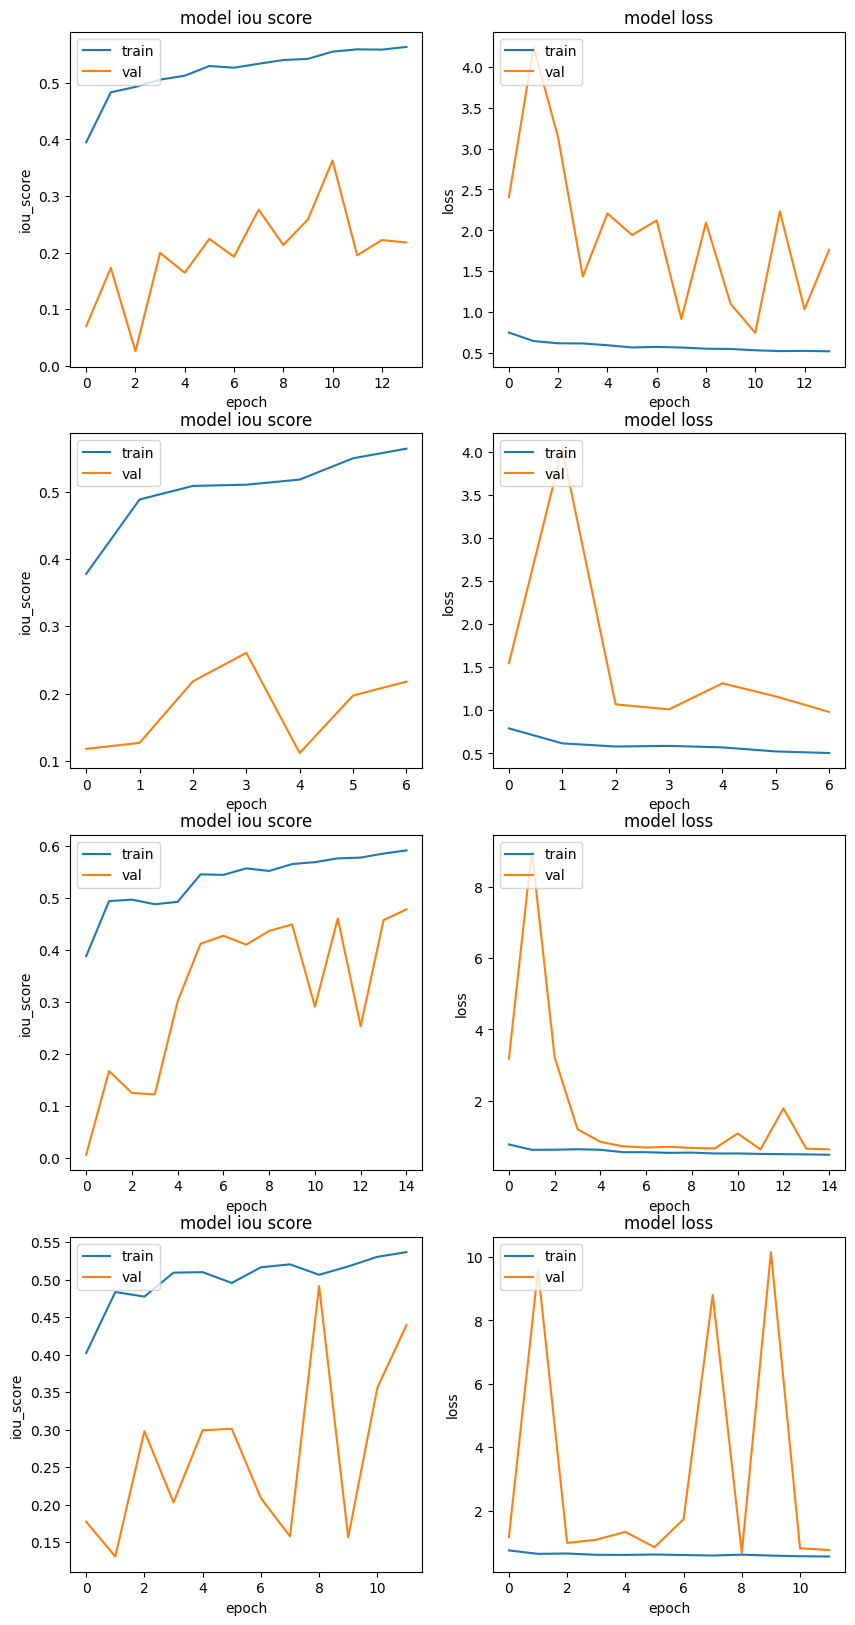

In [98]:
plot_histories(history_per_fold)

## Model Evaluation

In [99]:
test_dataset = Dataset(
    image_paths_test,
    mask_paths_test,
    augmentation=get_validation_augmentation(Height=HEIGHT, Width=WIDTH),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
n images: 3


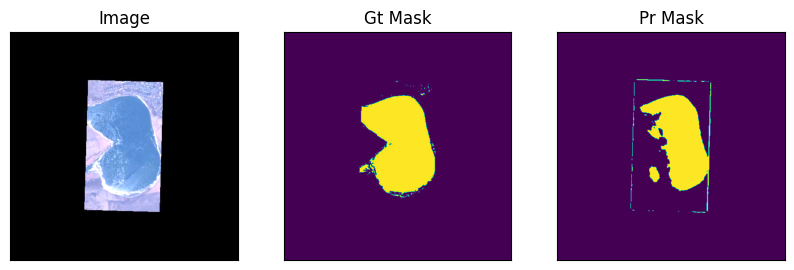

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
n images: 3


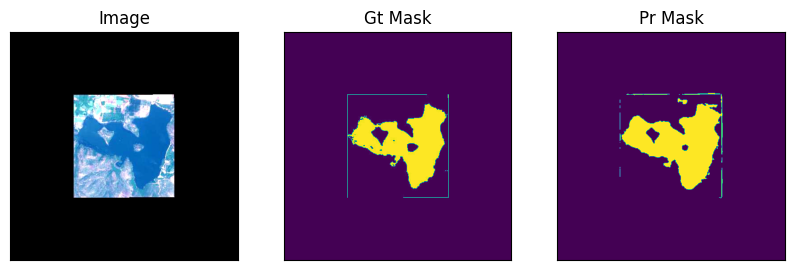

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
n images: 3


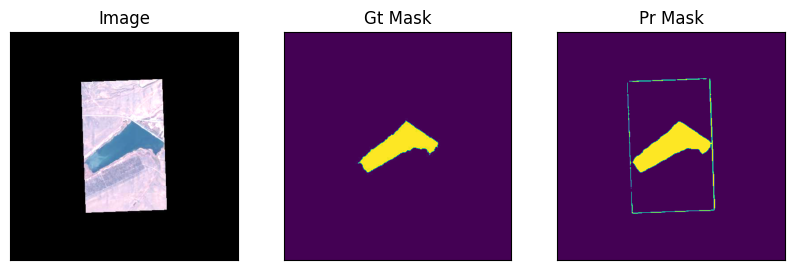

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
n images: 3


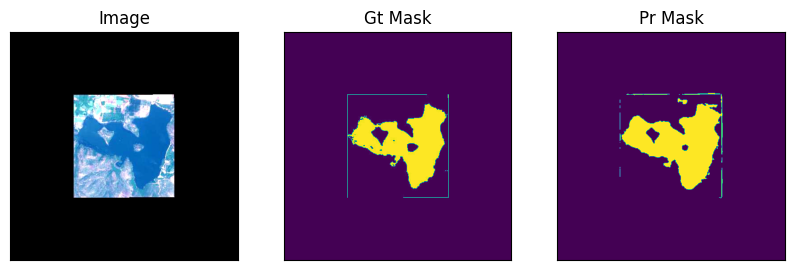

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
n images: 3


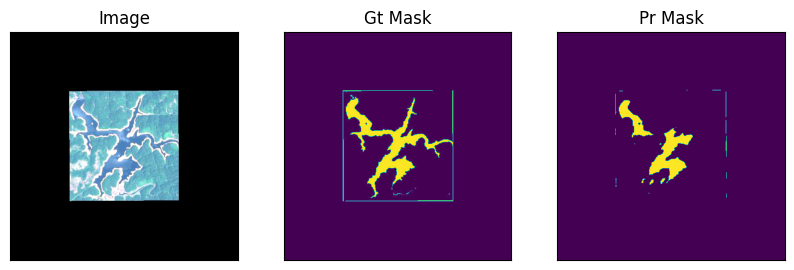

In [103]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask,
        pr_mask=pr_mask.squeeze(),
    )

In [101]:
fpath = os.path.join(ROOTPATH, 'models', 'keras_tensorflow_unet', ENCODER, 'best_model.keras')
loaded_model = keras.models.load_model(fpath, compile=False)

In [102]:
scores = model.evaluate(test_dataloader)

print("IOU: {:.5}".format(scores[1]))
print("Loss: {:.5}, ".format(scores[0]))


# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# for metric, value in zip(metrics, scores[1:]):
#     print("mean {}: {:.5}".format(metric.__name__, value))

427/427 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - iou_score: 0.4626 - loss: 0.6831
IOU: 0.45905
Loss: 0.69177, 
